In [1]:
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.engine import training
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras import Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Average
from keras.applications.nasnet import NASNetLarge, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np 
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from scipy import stats
from statistics import mean
from keras.models import load_model

In [2]:

BATCH_SIZE = 8

train_generator = ImageDataGenerator(rescale=1./255) 

val_generator = ImageDataGenerator(rescale=1./255)

test_generator = ImageDataGenerator(rescale=1./255)


In [3]:
train_data_dir = '../mice data/train'
val_data_dir = '../mice data/val'
test_data_dir = '../mice data/test'



traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,
                                               subset='training',
                                               seed=42)

validgen = val_generator.flow_from_directory(val_data_dir,
                                             target_size=(224, 224),
                                             batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             batch_size=BATCH_SIZE,
                                             
                                             shuffle=False,
                                             seed=42)

Found 209 images belonging to 3 classes.
Found 99 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


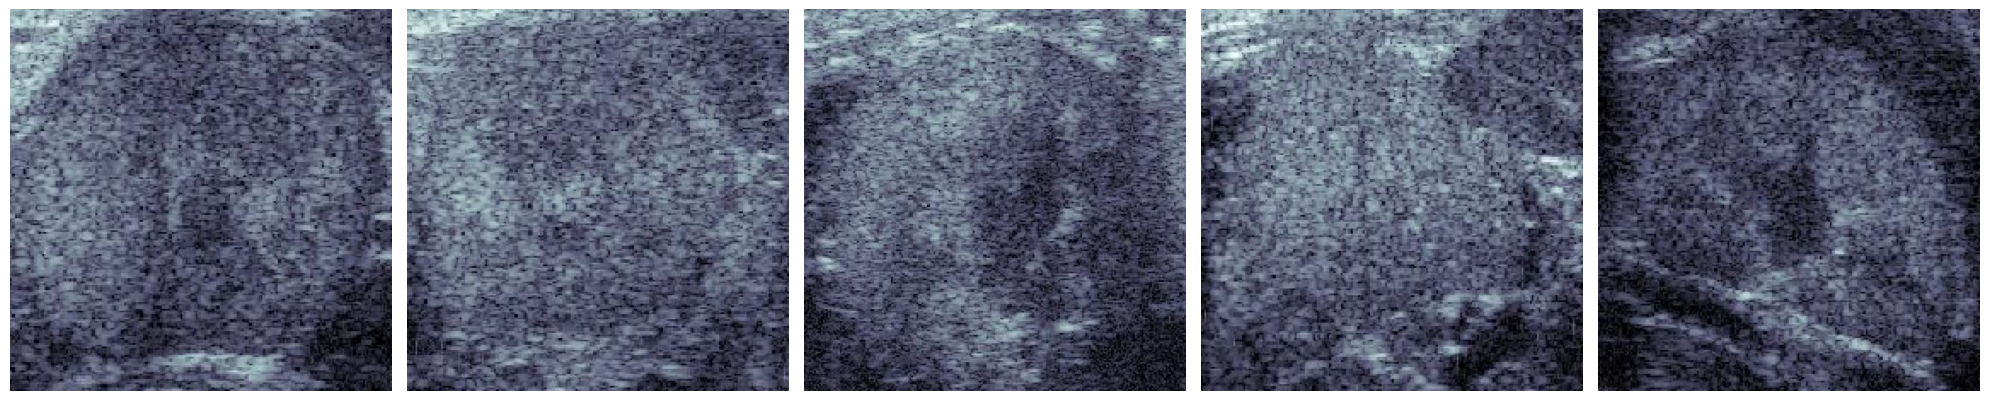

In [4]:
import matplotlib.pyplot as plt
sample_training_images, _ = next(traingen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10])

In [5]:
input_shape = (224, 224, 3)
optimizer = Adam(learning_rate=0.001)
n_classes= len(traingen.class_indices)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100
model_input = Input(shape=input_shape)

# NasNetLarge

In [6]:
def nasnetlarge(model_input: Tensor, optimizer) -> training.Model:
    conv_base = NASNetLarge(include_top = False,
                weights = 'imagenet',
                input_shape = input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = Flatten()(conv_base.output)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs = conv_base.input, outputs= output_layer, name='nasnetlarge_model')
    model.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model

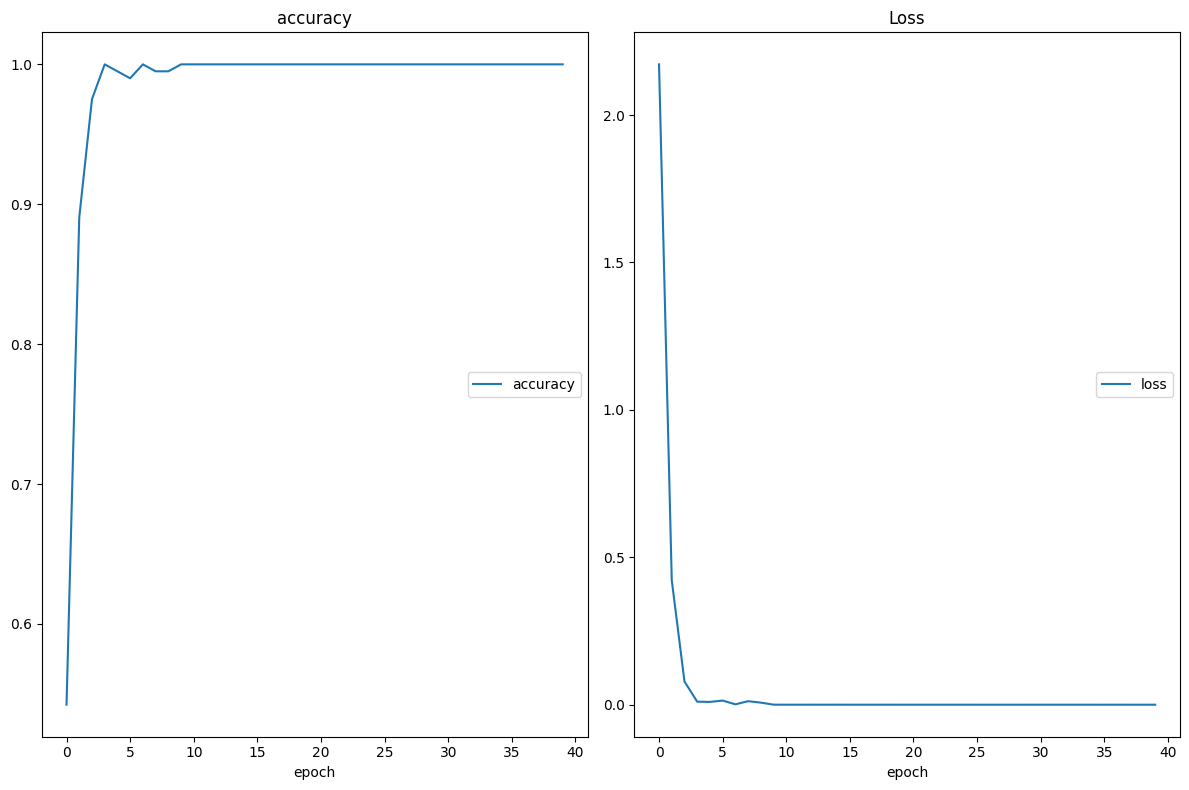

accuracy
	accuracy         	 (min:    0.542, max:    1.000, cur:    1.000)
Loss
	loss             	 (min:    0.000, max:    2.172, cur:    0.000)
26/26 [==============================] - 44s 2s/step - loss: 1.8447e-06 - accuracy: 1.0000


In [7]:
nasnetlarge_model = nasnetlarge(model_input, optimizer)
plot_loss_nasnetlarge = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_nasnetlarge = ModelCheckpoint(filepath='tl_model_nonprocessed_nasnetlarge_medium.weights.best.hdf5',
                                            monitor='loss',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                        patience=10,
                        restore_best_weights=True,
                        mode='min')

nasnetlarge_history = nasnetlarge_model.fit(traingen,
        batch_size=BATCH_SIZE,
        epochs= n_epochs,
        shuffle= True,
        steps_per_epoch=n_steps,
        callbacks=[tl_checkpoint_nasnetlarge, early_stop, plot_loss_nasnetlarge],
        verbose=1)

5/5 [==============================] - 7s 708ms/step
{'accuracy': 0.42424242424242425, 'balanced_acc': 0.47222222222222215, 'precision': array([0.3       , 0.66666667, 0.45      ]), 'f1': array([0.35146444, 0.51851852, 0.43674177]), 'sensitivity': 0.42424242424242425, 'specificity': 0.712121212121212, 'g_mean': 0.5496471862793046}


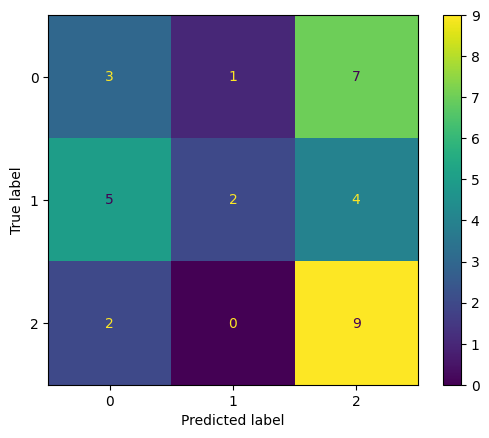

In [7]:
nasnetlarge_model = nasnetlarge(model_input, optimizer)
nasnetlarge_model.load_weights("tl_model_nonprocessed_nasnetlarge_medium.weights.best.hdf5")

y_prob = nasnetlarge_model.predict(testgen)
y_pred = y_prob.argmax(axis=-1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test = testgen.classes
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, jaccard_score, roc_auc_score

acc = accuracy_score(y_pred, y_test)
balanced_acc = balanced_accuracy_score(y_pred, y_test)

#auc = roc_auc_score(y_score = y_pred, y_true = y_test, multi_class="ovr")
precision = np.diag(cm) / np.sum(cm, axis = 0)
def sensitivity(y_true,y_pred):
        cm=confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        Sensitivity = TP/(TP+FN)    
        return np.mean(Sensitivity)

sens = sensitivity(y_test, y_pred)
def specificity(y_true,y_pred):
        cm=confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        Specificity = TN/(TN+FP)    
        return np.mean(Specificity)
specif= specificity(y_test, y_pred)

f1 = 2 * (precision * sens) / (precision + sens)

import math
g_mean = math.sqrt(sens * specif)

data = {
    "accuracy" : acc,
    "balanced_acc" : balanced_acc,
    "precision": precision,
    "f1": f1,
    "sensitivity": sens,
    "specificity": specif,
    "g_mean": g_mean
}
print(data)